In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from urllib.request import urlopen
from imageio import imread
import requests
import io
from time import time

import cv2 
import os, shutil


import warnings
warnings.filterwarnings('ignore')

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
# %load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)>0:
    tf.config.experimental.set_memory_growth(gpus[0] , True)
    print('Running on GPU ...')
else:
    print('Running on CPU ...')



Running on CPU ...


In [1]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', 
                                       monitor='val_acc',
                                       mode='max',
                                       save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=f'logs', update_freq=100),
]

In [2]:
images_dir = r'C:\Users\sraeisi\Documents\Datasets\Physics\Galaxies\images_training_rev1'
labels = r'C:\Users\sraeisi\Documents\Datasets\Physics\Galaxies\training_solutions_rev1.zip'
# test_img_dir=r'C:\Users\sraeisi\Documents\Datasets\Physics\Galaxies\images_test_rev1'

In [3]:
batch_size = 16
n_w = 100
n_h = 100
n_c = 3 ## Number of channels
n_classes = 3 # This is only for the first question. 

# The number of steps in each epoch
stp_epch =  100 #int(61578/ batch_size)+1

In [14]:
'''
We can check if the GPU is available.
'''
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5672148267032215316
]


# Data: Question 1

In [10]:
## We first need to create the labels. We generate a dataframe for that. 
## The following df contains a subset of the target values, namely, 
## only the response to the first question.

df = pd.read_csv(labels, compression='zip', usecols=['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3'])
df['GalaxyID'] = df['GalaxyID'].astype(str)+'.jpg'
df['label'] = np.argmax(df.drop(['GalaxyID'], axis=1).values, axis=1 ).astype(str)
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,label
0,100008.jpg,0.383147,0.616853,0.000000,1
1,100023.jpg,0.327001,0.663777,0.009222,1
2,100053.jpg,0.765717,0.177352,0.056931,0
3,100078.jpg,0.693377,0.238564,0.068059,0
4,100090.jpg,0.933839,0.000000,0.066161,0


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   rotation_range=180, 
                                   validation_split=0.25)

train_generator = train_datagen.flow_from_dataframe( dataframe=df,
                                                   directory=images_dir,
                                                   x_col = 'GalaxyID', 
                                                   y_col = ['Class1.1','Class1.2','Class1.3'], 
                                                   class_mode='raw', 
                                                   target_size=(n_w, n_h), 
                                                   batch_size=batch_size,
                                                   shuffle=True, 
                                                   subset='training')


validation_generator = train_datagen.flow_from_dataframe( dataframe=df,
                                                   directory=images_dir,
                                                   x_col = 'GalaxyID', 
                                                   y_col = ['Class1.1','Class1.2','Class1.3'], 
                                                   class_mode='raw', 
                                                   target_size=(n_w, n_h), 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   subset='validation')

Found 46184 validated image filenames.
Found 15394 validated image filenames.


In [12]:
train_generator[0][1].shape

(16, 3)

data batch shape: (16, 100, 100, 3)
labels batch shape: (16, 3)


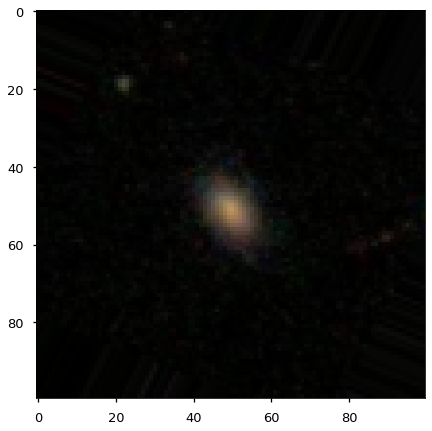

In [29]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
plt.imshow(data_batch[13])   
plt.show()

## Non-CNN Network

In [24]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Flatten(input_shape=(n_w , n_h,  n_c) ))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3840128   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 3,840,515
Trainable params: 3,840,515
Non-trainable params: 0
_________________________________________________________________


In [22]:
train_generator[0][0].shape

(64, 100, 100, 3)

In [30]:
%%time
history = model.fit(train_generator, 
                    steps_per_epoch=stp_epch, 
                    validation_data=validation_generator,
                    validation_steps=10, 
                    callbacks=my_callbacks, 
                    verbose=1, 
                    epochs=10)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 10 steps
Epoch 1/10
100/100 [==============================] - 40s 404ms/step - loss: 0.8911 - accuracy: 0.6044 - val_loss: 1.0334 - val_accuracy: 0.6250
Epoch 2/10
100/100 [==============================] - 37s 374ms/step - loss: 0.8795 - accuracy: 0.5944 - val_loss: 0.7894 - val_accuracy: 0.6000
Epoch 3/10
100/100 [==============================] - 39s 392ms/step - loss: 0.7821 - accuracy: 0.6594 - val_loss: 0.7866 - val_accuracy: 0.6687
Epoch 4/10
100/100 [==============================] - 41s 406ms/step - loss: 0.7803 - accuracy: 0.6394 - val_loss: 0.7859 - val_accuracy: 0.6375
Epoch 5/10
100/100 [==============================] - 37s 373ms/step - loss: 0.7597 - accuracy: 0.6694 - val_loss: 0.7873 - val_accuracy: 0.6500
Epoch 6/10
100/100 [==============================] - 37s 369ms/step - loss: 0.7665 - accuracy: 0.6712 - val_loss: 0.7916 - val_accuracy: 0.6875
Epoch 7/10
100/100 [=================

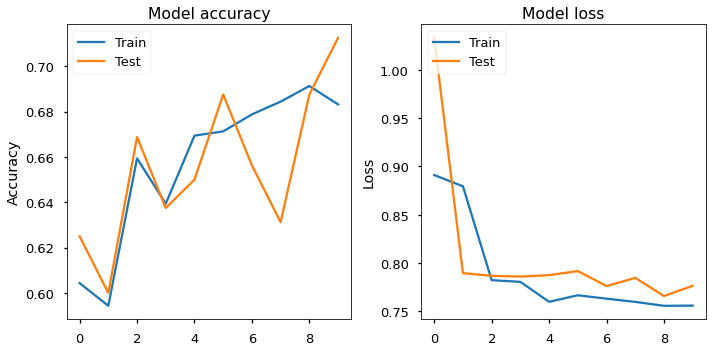

In [31]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Initial CNN Model

In [32]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(n_w , n_h, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((3, 3)))
# model.add(layers.Conv2D(64, (5, 5), activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)        

In [33]:
model.compile(loss=keras.losses.mean_squared_error, 
             optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])

In [34]:
%%time
history = model.fit(train_generator, 
                    steps_per_epoch=stp_epch, 
                    validation_data=validation_generator,
                    validation_steps=10, 
                    callbacks=my_callbacks, 
                    verbose=1, 
                    epochs=5)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 10 steps
Epoch 1/5
100/100 [==============================] - 39s 389ms/step - loss: 0.0648 - accuracy: 0.5575 - val_loss: 0.0512 - val_accuracy: 0.5625
Epoch 2/5
100/100 [==============================] - 35s 352ms/step - loss: 0.0534 - accuracy: 0.5981 - val_loss: 0.0491 - val_accuracy: 0.6000
Epoch 3/5
100/100 [==============================] - 36s 356ms/step - loss: 0.0525 - accuracy: 0.6200 - val_loss: 0.0471 - val_accuracy: 0.6375
Epoch 4/5
100/100 [==============================] - 36s 358ms/step - loss: 0.0491 - accuracy: 0.6531 - val_loss: 0.0468 - val_accuracy: 0.6313
Epoch 5/5
100/100 [==============================] - 37s 366ms/step - loss: 0.0477 - accuracy: 0.6619 - val_loss: 0.0444 - val_accuracy: 0.6500
Wall time: 3min 3s


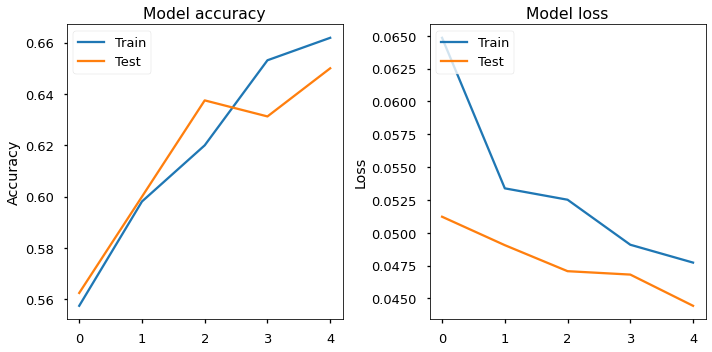

In [36]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [35]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights=None, include_top=True, input_shape=(n_w, n_h, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [38]:
%%time
model.compile(loss=keras.losses.mean_squared_error, 
             optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])

history = model.fit(train_generator, 
                    steps_per_epoch=100, 
                    validation_data=validation_generator,
                    validation_steps=10, 
                    callbacks=my_callbacks, 
                    verbose=1, 
                    epochs=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 10 steps
100/100 [==============================] - 35s 350ms/step - loss: 0.0446 - accuracy: 0.6900 - val_loss: 0.0492 - val_accuracy: 0.5875
Wall time: 35.9 s


# Pretrained models

## Pretrained VGG16 as a feature extractor

In [36]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(n_w, n_h, 3))

In [14]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [15]:
conv_base_out = conv_base.layers[-1].output_shape[1:]
n_features = np.prod(conv_base_out)
print(n_features)
conv_base_out

4608


(3, 3, 512)

In [16]:
'''
This function is to exctract features from the images. 
This is done based VGG16 convnet. 
This function does the following

X, Y => f(X), Y

where f(x) is the feasures extracted from the images. 

'''

def extract_features(network, generator, sample_count):
    ## This is set based on the shape of the last layer of the VGG16
    features = np.zeros(shape=(sample_count, conv_base_out[0], 
                               conv_base_out[1], 
                              conv_base_out[2])
                       )
    labels = np.zeros(shape=(sample_count, n_classes))

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = network.predict(inputs_batch)
#         print(labels_batch.shape)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
#         print(i)
        if i * batch_size >= sample_count:
            break
    return features, labels

In [17]:
%%time 
train_features, train_labels = extract_features(conv_base, train_generator, 100*batch_size)
validation_features, validation_labels = extract_features(conv_base, validation_generator, 10*batch_size)

Wall time: 2min 34s


In [20]:
## The data needs to be flattened. 
train_features = np.reshape(train_features, (100*batch_size, n_features ))
validation_features = np.reshape(validation_features, (10*batch_size, n_features ))

In [37]:
'''
Now let's make our new model.
'''
feature_based_model = models.Sequential()

# pre_trained_model.add(conv_base)

# pre_trained_model.add(layers.Flatten())

feature_based_model.add(layers.Dense(256, activation='relu', input_dim=n_features))
# pre_trained_model.add(layers.Dropout(0.5))

feature_based_model.add(layers.Dense(3, activation='softmax'))

feature_based_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])

feature_based_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 771       
Total params: 1,180,675
Trainable params: 1,180,675
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = feature_based_model.fit(train_features, train_labels, 
                                epochs=5, 
                                batch_size=batch_size, 
                                validation_data= (validation_features, validation_labels),
                                callbacks=my_callbacks, 
                                verbose=1 )

Train on 1600 samples, validate on 160 samples
Epoch 1/5
1600/1600 [==============================] - 2s 1ms/sample - loss: 0.0601 - accuracy: 0.6219 - val_loss: 0.0367 - val_accuracy: 0.7375
Epoch 2/5
1600/1600 [==============================] - 1s 792us/sample - loss: 0.0430 - accuracy: 0.6944 - val_loss: 0.0336 - val_accuracy: 0.7250
Epoch 3/5
1600/1600 [==============================] - 1s 807us/sample - loss: 0.0395 - accuracy: 0.7269 - val_loss: 0.0318 - val_accuracy: 0.7500
Epoch 4/5
1600/1600 [==============================] - 1s 837us/sample - loss: 0.0386 - accuracy: 0.7163 - val_loss: 0.0314 - val_accuracy: 0.7625
Epoch 5/5
1600/1600 [==============================] - 1s 838us/sample - loss: 0.0374 - accuracy: 0.7337 - val_loss: 0.0312 - val_accuracy: 0.7500


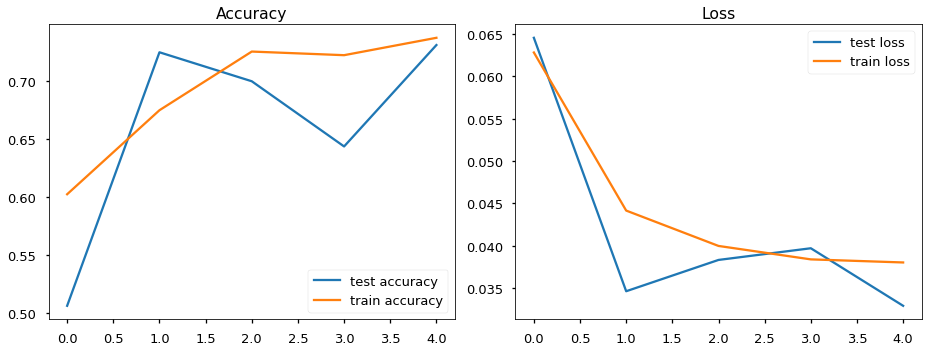

In [22]:
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


## Freezed pretrained VGG16 + trainable estimator at the end

In [ ]:
conv_base.trainable = False

In [27]:
'''
Now let's make our new model.
'''
pre_trained_model = models.Sequential()

pre_trained_model.add(conv_base)

pre_trained_model.add(layers.Flatten())

pre_trained_model.add(layers.Dense(256, activation='relu' ))
# pre_trained_model.add(layers.Dropout(0.5))

pre_trained_model.add(layers.Dense(3, activation='softmax'))

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])

pre_trained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 15,895,363
Trainable params: 15,895,363
Non-trainable params: 0
_________________________________________________________________


In [29]:
conv_base.trainable = False
conv_base.trainable

False

In [30]:
%%time
############### Training the model

history = pre_trained_model.fit(train_generator, 
                    steps_per_epoch  = stp_epch, 
                    validation_data  = validation_generator,
                    validation_steps = 5, 
                    callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 5)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 5 steps
10/10 [==============================] - 59s 6s/step - loss: 0.1044 - accuracy: 0.5188 - val_loss: 0.0472 - val_accuracy: 0.6000
Wall time: 1min


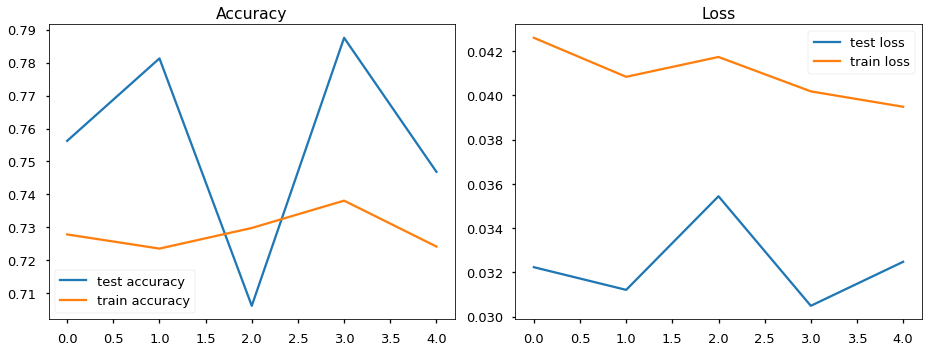

In [69]:
##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()

## Partially freezed pretrained VGG16 + trainable estimator at the end

In [32]:
conv_base.trainble = False

# We can freeze all bu the last two layers. 
for layer in conv_base.layers[-3:]:
    layer.trainable = True

## We can check which layers are traible. 
i=0    
for layer in conv_base.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(i,layer.trainable)  )    

Layer 1 is trainable: False
Layer 2 is trainable: False
Layer 3 is trainable: False
Layer 4 is trainable: False
Layer 5 is trainable: False
Layer 6 is trainable: False
Layer 7 is trainable: False
Layer 8 is trainable: False
Layer 9 is trainable: False
Layer 10 is trainable: False
Layer 11 is trainable: False
Layer 12 is trainable: False
Layer 13 is trainable: False
Layer 14 is trainable: False
Layer 15 is trainable: False
Layer 16 is trainable: False
Layer 17 is trainable: True
Layer 18 is trainable: True
Layer 19 is trainable: True


In [33]:
for layer in pre_trained_model.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(layer.name , layer.trainable)  )    

Layer vgg16 is trainable: False
Layer flatten_1 is trainable: True
Layer sequential_2 is trainable: True


In [39]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)
pre_trained_model.add(layers.Flatten())
pre_trained_model.add(feature_based_model)

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])


pre_trained_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 3)                 1180675   
Total params: 15,895,363
Trainable params: 15,895,363
Non-trainable params: 0
_________________________________________________________________


In [89]:
validation_generator[0][0].shape
y_prd = pre_trained_model.predict(validation_generator[0][0])
validation_generator[0][1].shape

(64, 3)

In [40]:
from tensorflow.keras.losses import mean_squared_error
from sklearn.metrics import accuracy_score

loss = 0
acc = 0
n_val =10

for i in range(n_val):
    d = validation_generator[i]
    y_prd = pre_trained_model.predict(d[0])

    loss += mean_squared_error(y_prd, d[1]).numpy().mean()/n_val
    acc += accuracy_score( y_prd.argmax(axis=1),   d[1].argmax(axis=1) )/n_val


print(f'The score before training is {acc}.')

The score before training is 0.7437499999999999.


In [56]:

pre_trained_model = models.Sequential()

pre_trained_model.add(conv_base)

pre_trained_model.add(layers.Flatten())

pre_trained_model.add( pre_trained_model )
pre_trained_model.add(layers.Dropout(0.5))

pre_trained_model.add(layers.Dense(3, activation='softmax'))

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])



In [41]:
%%time

## Reset the model
# pre_trained_model.reset_states


############### Training the model

history = pre_trained_model.fit(train_generator, 
                    steps_per_epoch  = stp_epch, 
                    validation_data  = validation_generator,
                    validation_steps = 5, 
                    callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 1)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 5 steps
100/100 [==============================] - 475s 5s/step - loss: 0.0476 - accuracy: 0.6787 - val_loss: 0.0327 - val_accuracy: 0.6875
Wall time: 7min 56s


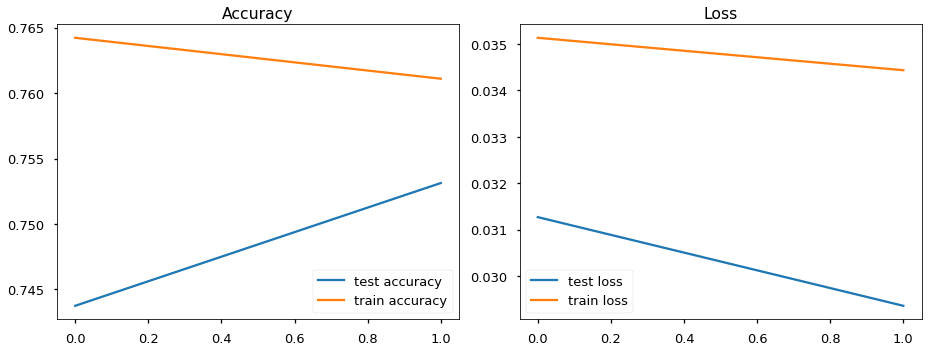

In [116]:


##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


# Full estimation of the labels

In [4]:
df = pd.read_csv(labels)
df['GalaxyID'] = df['GalaxyID'].astype(str)+'.jpg'
df.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008.jpg,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023.jpg,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053.jpg,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078.jpg,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090.jpg,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [7]:
label_cols = df.columns[1:]
n_classes = len(label_cols)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   rotation_range=180, 
                                   validation_split=0.25)

train_generator = train_datagen.flow_from_dataframe( dataframe=df,
                                                   directory=images_dir,
                                                   x_col = 'GalaxyID', 
                                                   y_col = label_cols, 
                                                   class_mode='raw', 
                                                   target_size=(n_w, n_h), 
                                                   batch_size=batch_size,
                                                   shuffle=True, 
                                                   subset='training')


validation_generator = train_datagen.flow_from_dataframe( dataframe=df,
                                                   directory=images_dir,
                                                   x_col = 'GalaxyID', 
                                                   y_col = label_cols, 
                                                   class_mode='raw', 
                                                   target_size=(n_w, n_h), 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   subset='validation')



ModuleNotFoundError: No module named 'tf'

In [8]:
from tf.keras.applications import VGG16
conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(n_w, n_h, 3))
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
bloc

In [25]:
out_lay = conv_base.layers[-1]
con_base_out_d = out_lay.output_shape[1]

In [25]:
def extract_features(network, generator, sample_count):
    features = np.zeros(shape=(sample_count, con_base_out_d, con_base_out_d, 512))
    labels = np.zeros(shape=(sample_count, n_classes))

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = network.predict(inputs_batch)
#         print(features_batch.shape)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
#         print(i)
        if i * batch_size >= sample_count:
            break
    return features, labels

In [32]:
%%time 
train_features, train_labels = extract_features(conv_base, train_generator, 150*batch_size)
validation_features, validation_labels = extract_features(conv_base, validation_generator, 20*batch_size)

Wall time: 9min 29s


In [36]:
train_features = np.reshape(train_features, (150*batch_size, con_base_out_d * con_base_out_d * 512))
validation_features = np.reshape(validation_features, (20*batch_size, con_base_out_d * con_base_out_d * 512))

In [39]:
'''
Now let's make our new model.
'''
pre_trained_model = models.Sequential()

# pre_trained_model.add(conv_base)

# pre_trained_model.add(ks.layers.Flatten())

pre_trained_model.add(layers.Dense(1024, activation='relu', input_dim=con_base_out_d * con_base_out_d * 512))
pre_trained_model.add(layers.Dropout(0.15))

pre_trained_model.add(layers.Dense(256, activation='relu'))
pre_trained_model.add(layers.Dropout(0.15))


pre_trained_model.add(layers.Dense(n_classes, activation='sigmoid'))

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['acc', 'MSE'])
pre_trained_model.optimizer = tf.keras.optimizers.RMSprop(lr=1e-6)
pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 37)                9509      
Total params: 19,147,301
Trainable params: 19,147,301
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 38400 samples, validate on 5120 samples
Epoch 1/100
38400/38400 [==============================] - 15s 386us/step - loss: 0.1285 - acc: 0.3278 - mean_squared_error: 0.1285 - val_loss: 0.0784 - val_acc: 0.6033 - val_mean_squared_error: 0.0784
Epoch 2/100
38400/38400 [==============================] - 13s 351us/step - loss: 0.0673 - acc: 0.5828 - mean_squared_error: 0.0673 - val_loss: 0.0419 - val_acc: 0.6033 - val_mean_squared_error: 0.0419
Epoch 3/100
38400/38400 [==============================] - 16s 409us/step - loss: 0.0437 - acc: 0.5799 - mean_squared_error: 0.0437 - val_loss: 0.0302 - val_acc: 0.6033 - val_mean_squared_error: 0.0302
Epoch 4/100
38400/38400 [==============================] - 16s 414us/step - loss: 0.0361 - acc: 0.5705 - mean_squared_error: 0.0361 - val_loss: 0.0275 - val_acc: 0.6033 - val_mean_squared_error: 0.0275
Epoch 5/100
38400/38400 [==============================] - 17s 432us/step - loss: 0.0339 - acc:

Epoch 40/100
38400/38400 [==============================] - 14s 368us/step - loss: 0.0238 - acc: 0.5974 - mean_squared_error: 0.0238 - val_loss: 0.0198 - val_acc: 0.6395 - val_mean_squared_error: 0.0198
Epoch 41/100
38400/38400 [==============================] - 15s 381us/step - loss: 0.0236 - acc: 0.5955 - mean_squared_error: 0.0236 - val_loss: 0.0197 - val_acc: 0.6406 - val_mean_squared_error: 0.0197
Epoch 42/100
38400/38400 [==============================] - 15s 382us/step - loss: 0.0235 - acc: 0.5972 - mean_squared_error: 0.0235 - val_loss: 0.0196 - val_acc: 0.6416 - val_mean_squared_error: 0.0196
Epoch 43/100
38400/38400 [==============================] - 14s 373us/step - loss: 0.0233 - acc: 0.5991 - mean_squared_error: 0.0233 - val_loss: 0.0195 - val_acc: 0.6422 - val_mean_squared_error: 0.0195
Epoch 44/100
38400/38400 [==============================] - 16s 427us/step - loss: 0.0232 - acc: 0.5993 - mean_squared_error: 0.0232 - val_loss: 0.0194 - val_acc: 0.6443 - val_mean_squared

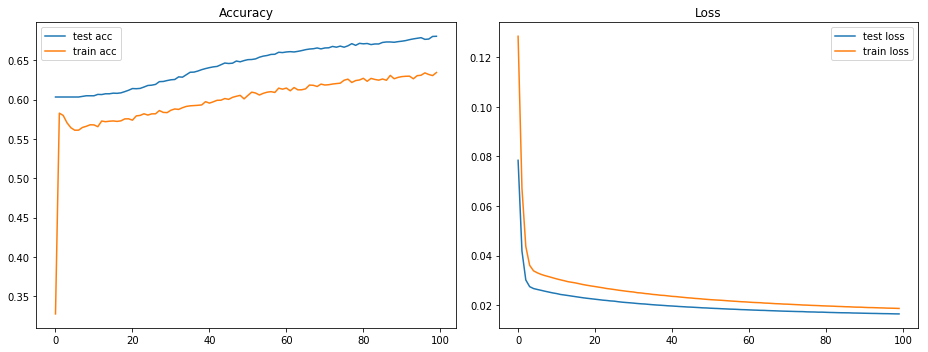

In [40]:
history = pre_trained_model.fit(train_features, train_labels, 
                                epochs=100, 
                                batch_size=batch_size, 
                                validation_data= (validation_features, validation_labels)
                                callbacks=my_callbacks, 
                                verbose=1 )


##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


In [41]:
'''
You can use save to save the model or use pickle. 
'''
pre_trained_model.save('150B_200pxl_fc1024_fc256.model')

In [45]:
import pickle

with open('150B_200pxl_fc1024_fc256_hist', 'wb') as f:
        pickle.dump(history.history, f)

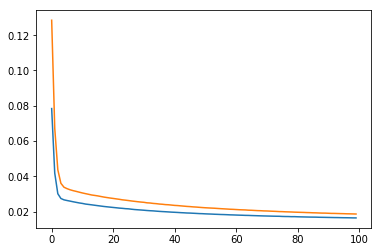

In [53]:
with open('150B_200pxl_fc1024_fc256_hist', 'rb') as f:
        hist = pickle.load(f)

plt.plot(hist['val_mean_squared_error'])
plt.plot(hist['mean_squared_error'])

## Using pretrained networks

### Freezed pretrained VGG16 + trainable estimator at the end

In [ ]:
conv_base.trainable = False

In [42]:
'''
Now let's make our new model.
'''
pre_trained_model = models.Sequential()

pre_trained_model.add(conv_base)

pre_trained_model.add(layers.Flatten())

pre_trained_model.add(layers.Dense(256, activation='relu' ))
pre_trained_model.add(layers.Dropout(0.5))

pre_trained_model.add(layers.Dense(3, activation='softmax'))

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])

pre_trained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 15,895,363
Trainable params: 1,180,675
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
# conv_base.trainable = False
pre_trained_model.trainable_weights

[<tf.Variable 'dense_7/kernel:0' shape=(4608, 256) dtype=float32_ref>,
 <tf.Variable 'dense_7/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense_8/kernel:0' shape=(256, 3) dtype=float32_ref>,
 <tf.Variable 'dense_8/bias:0' shape=(3,) dtype=float32_ref>]

Epoch 1/2
241/241 [==============================] - 233s 967ms/step - loss: 0.0441 - acc: 0.7052 - val_loss: 0.0346 - val_acc: 0.7688
Epoch 2/2
241/241 [==============================] - 253s 1s/step - loss: 0.0355 - acc: 0.7643 - val_loss: 0.0316 - val_acc: 0.7806


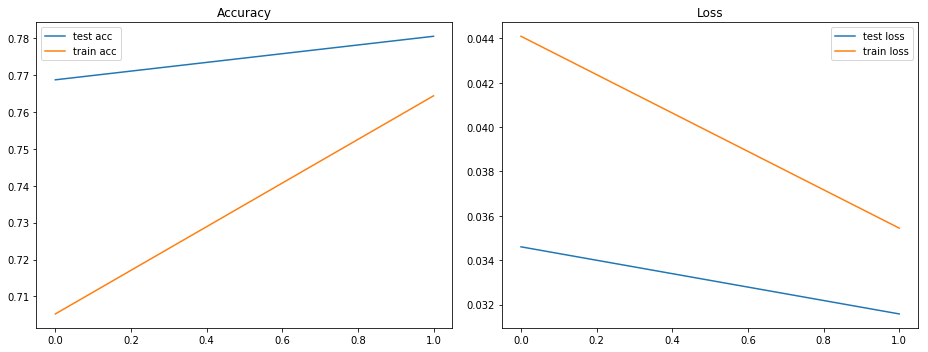

Wall time: 8min 6s


In [44]:
%%time
############### Training the model

history = pre_trained_model.fit(train_generator, 
                    steps_per_epoch  = stp_epch, 
                    validation_data  = validation_generator,
                    validation_steps = stp_epch, 
                    callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 10)


##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()



### Partially freezed pretrained VGG16 + trainable estimator at the end

In [54]:
conv_base.trainble = True

# We can freeze all bu the last two layers. 
for layer in conv_base.layers[:-2]:
    layer.trainable = False

## We can check which layers are traible. 
i=0    
for layer in conv_base.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(i,layer.trainable)  )    

Layer 1 is trainable: False
Layer 2 is trainable: False
Layer 3 is trainable: False
Layer 4 is trainable: False
Layer 5 is trainable: False
Layer 6 is trainable: False
Layer 7 is trainable: False
Layer 8 is trainable: False
Layer 9 is trainable: False
Layer 10 is trainable: False
Layer 11 is trainable: False
Layer 12 is trainable: False
Layer 13 is trainable: False
Layer 14 is trainable: False
Layer 15 is trainable: False
Layer 16 is trainable: False
Layer 17 is trainable: False
Layer 18 is trainable: True
Layer 19 is trainable: True


In [56]:

pre_trained_model = models.Sequential()

pre_trained_model.add(conv_base)

pre_trained_model.add(layers.Flatten())

pre_trained_model.add(layers.Dense(256, activation='relu' ))
pre_trained_model.add(layers.Dropout(0.5))

pre_trained_model.add(layers.Dense(3, activation='softmax'))

pre_trained_model.compile(loss=tf.keras.losses.mean_squared_error, 
             optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy'])



Epoch 1/2
241/241 [==============================] - 217s 899ms/step - loss: 0.0443 - acc: 0.7015 - val_loss: 0.0345 - val_acc: 0.7721
Epoch 2/2
241/241 [==============================] - 351s 1s/step - loss: 0.0357 - acc: 0.7635 - val_loss: 0.0321 - val_acc: 0.7731


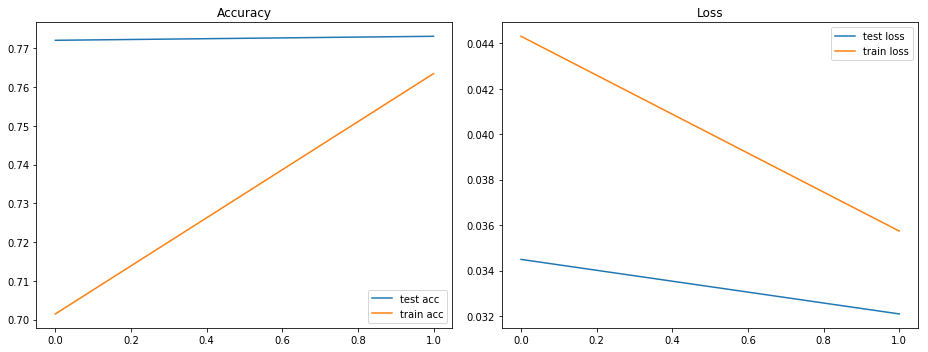

Wall time: 9min 28s


In [57]:
%%time

## Reset the model
# pre_trained_model.reset_states


############### Training the model

history = pre_trained_model.fit(train_generator, 
                    steps_per_epoch  = stp_epch, 
                    validation_data  = validation_generator,
                    validation_steps = stp_epch, 
                    callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 10)


##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()


In [ ]:
model.save('150B_200pxl_fc1024_fc256.h5')

### Adding more trainable layers

In [9]:
my_model = ks.models.load_model('150B_200pxl_fc1024_fc256.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [10]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(n_w, n_h, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [11]:
label_cols = df.columns[1:]
n_classes = len(label_cols)

In [27]:
conv_base.trainble = True

# We can freeze all but the last two layers. 
for layer in conv_base.layers[:-5]:
    layer.trainable = False

## We can check which layers are traible. 
i=0    
for layer in conv_base.layers:
    i+=1
    print('Layer {} is trainable: {}'.format(i,layer.trainable)  )    

Layer 1 is trainable: False
Layer 2 is trainable: False
Layer 3 is trainable: False
Layer 4 is trainable: False
Layer 5 is trainable: False
Layer 6 is trainable: False
Layer 7 is trainable: False
Layer 8 is trainable: False
Layer 9 is trainable: False
Layer 10 is trainable: False
Layer 11 is trainable: False
Layer 12 is trainable: False
Layer 13 is trainable: False
Layer 14 is trainable: False
Layer 15 is trainable: False
Layer 16 is trainable: False
Layer 17 is trainable: False
Layer 18 is trainable: False
Layer 19 is trainable: True


In [28]:
ext_model = models.Sequential()
ext_model.add(conv_base)
ext_model.add(layers.Flatten())
ext_model.add(my_model)
ext_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 37)                19147301  
Total params: 33,861,989
Trainable params: 19,147,301
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (256, 200, 200, 3)
labels batch shape: (256, 37)


In [23]:
predicted_y = ext_model.predict(data_batch)
from sklearn.metrics import mean_squared_error
mean_squared_error(predicted_y, labels_batch)

0.017320873420552326

In [34]:
ext_model.compile(loss=losses.mean_squared_error, 
             optimizer=optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True), 
             metrics=['accuracy' , 'MSE'])


Epoch 1/2
482/482 [==============================] - 1177s 2s/step - loss: 0.0187 - acc: 0.6337 - mean_squared_error: 0.0187 - val_loss: 0.0165 - val_acc: 0.6805 - val_mean_squared_error: 0.0165
Epoch 2/2
482/482 [==============================] - 1651s 3s/step - loss: 0.0187 - acc: 0.6337 - mean_squared_error: 0.0187 - val_loss: 0.0165 - val_acc: 0.6805 - val_mean_squared_error: 0.0165


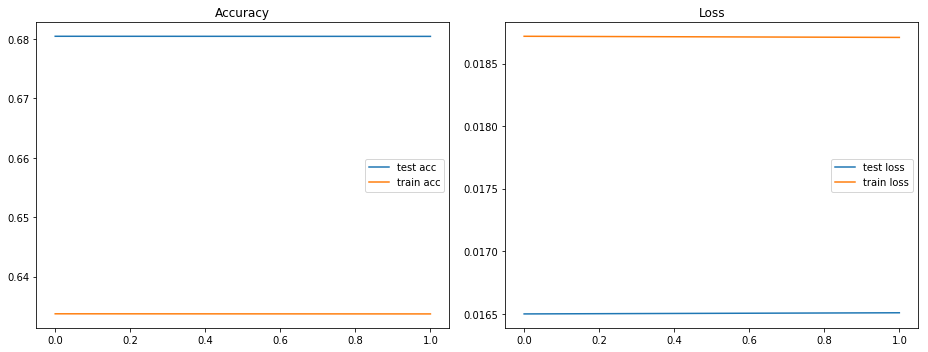

Wall time: 47min 9s


In [35]:
%%time
############### Training the model

history = ext_model.fit(train_generator, 
                    steps_per_epoch  = stp_epch, 
                    validation_data  = validation_generator,
                    validation_steps = stp_epch, 
                    callbacks = my_callbacks, 
                    verbose = 1, 
                    epochs = 10)


##############Plotting the result
fig = plt.figure(figsize=(13, 5))
ax  = fig.add_subplot(1,2,1, title='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.plot(history.history['accuracy'], label = 'train accuracy')
plt.legend(loc=0)

ax  = fig.add_subplot(1,2,2, title='Loss')
plt.plot(history.history['val_loss'], label = 'test loss')
plt.plot(history.history['loss'], label = 'train loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()
